# Police Stops Investigation

This notebook will describe the supervised learning problem, go through EDA procedures, perform analysis via model build/training, present results, and close with a discussion and conclusion.

## Project Topic/Supervised Learning Problem Description

We will use one or more **supervised learning** methods to predict whether or not an arrest is made based on input features of a particular police stop instance. This falls into the general space of **binary classification** problems. More specifically, the predicted variable will be `arrest_made` in the dataset (described below).

The **goal** of the project is to determine whether a large set of police stop data can be used to fit a model and predict arrests given available input features.

## Dataset Description

We'll be using police stop data from the Stanford Openpolicing project available at:

https://openpolicing.stanford.edu/data/

The data was originally collected and organized for the following research:

*E. Pierson, C. Simoiu, J. Overgoor, S. Corbett-Davies, D. Jenson, A. Shoemaker, V. Ramachandran, P. Barghouty, C. Phillips, R. Shroff, and S. Goel. “A large-scale analysis of racial disparities in police stops across the United States”. Nature Human Behaviour, Vol. 4, 2020.* Papar available at https://5harad.com/papers/100M-stops.pdf.

We will focus on data from Nashville, TN from 2010 to 2019. Specifics about the data for this location is outlined at https://github.com/stanford-policylab/opp/blob/master/data_readme.md#nashville-tn. Data for **3,092,351** police stops are available in the set, but further cleaning and analysis will likely result in using only a subset for model training.

The data is provided in **CSV format** with **42 columns**. The column names and coverage are available at the location-specific description at https://github.com/stanford-policylab/opp/blob/master/data_readme.md#nashville-tn. There is a mixture of numerical and categorical features.


# Data Loading and Imports

We first need to setup our common imports and load the data into a Pandas dataframe. The cell below is based on the standard template when creating a new Kaggle notebook and will list the available input files. We should see the following single input CSV listed when running the cell below:

```
/kaggle/input/police-stops-nashville-tn/tn_nashville_2020_04_01.csv
```

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score


# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/police-stops-nashville-tn/tn_nashville_2020_04_01.csv


# EDA - Exploratory Data Analysis (Loading/Cleaning)

The data can now be loaded into a Pandas dataframe to begin the cleaning and EDA process.

After the data is loaded, we'll use the `info()` method to display some basic information about the imported columns like name, non-null count, and datatype. This will also provide the total number of rows and columns imported. After getting an overview, we'll clean the data and perform some transformations to help with later analysis.

In [2]:
# Read subset of data for EDA. The full set has over 3M rows.
np.random.seed(42)
num_rows_approx=3_000_000
sample_rows=10_000
df = pd.read_csv(
    '/kaggle/input/police-stops-nashville-tn/tn_nashville_2020_04_01.csv',
    skiprows=lambda x: x != 0 and np.random.uniform() > sample_rows/num_rows_approx,
)
df_orig = df.copy()

In [3]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   raw_row_number                  10324 non-null  object 
 1   date                            10324 non-null  object 
 2   time                            10302 non-null  object 
 3   location                        10324 non-null  object 
 4   lat                             9735 non-null   float64
 5   lng                             9735 non-null   float64
 6   precinct                        9066 non-null   float64
 7   reporting_area                  9280 non-null   float64
 8   zone                            9066 non-null   float64
 9   subject_age                     10320 non-null  float64
 10  subject_race                    10318 non-null  object 
 11  subject_sex                     10278 non-null  object 
 12  officer_id_hash                 

## Initial Cleaning

A few items stick out as far as columns we'll need to focus on for data cleaning:
1. `raw_*` columns: These are raw columns that the researchers included with the dataset from before they performed some preprocessing. We'll drop these and focus on the provided "processed" columns for consistency.
1. `object` datatypes: We need to investigate whether these are categorical or some other form of text or object.
1. Low non-null counts: These indicate missing data. Depending on the type and meaning of the given feature, we'll look at either imputing or dropping.

### Drop Raw Columns

As explained in the [dataset description](https://github.com/stanford-policylab/opp/blob/master/data_readme.md#description-of-standardized-data), the `raw_` columns are passed through from the original pre-processed data. We will not use those columsn in this analysis, so we'll drop the `raw_` columns to avoid cluttering later visualizations and analysis.

In [4]:
drop_cols = [x for x in df.columns if x.startswith('raw_')]
df.drop(drop_cols, axis=1, inplace=True)
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   date                        10324 non-null  object 
 1   time                        10302 non-null  object 
 2   location                    10324 non-null  object 
 3   lat                         9735 non-null   float64
 4   lng                         9735 non-null   float64
 5   precinct                    9066 non-null   float64
 6   reporting_area              9280 non-null   float64
 7   zone                        9066 non-null   float64
 8   subject_age                 10320 non-null  float64
 9   subject_race                10318 non-null  object 
 10  subject_sex                 10278 non-null  object 
 11  officer_id_hash             10324 non-null  object 
 12  type                        10324 non-null  object 
 13  violation                   103

## Sparse Data

The `info()` output reveals a few columns that are relatively sparse based on the *Non-Null Count* values. Some of these may still be valuable features, but we'll need to fill the Null/NaN values since model training visualization won't automatically NaNs.

### Contraband Columns

We'll first look at the `contraband_*` columns, which have a large number of Null values. Additionally, the datatype of these columsn is `object` and need to be converted to a usable value. In this case, the values are True/False, which we'll conver to boolean after backfilling the NaN values with False.

In [5]:
# Backfill NaN with False.
df.contraband_found.fillna(False, inplace=True)
df.contraband_drugs.fillna(False, inplace=True)
df.contraband_weapons.fillna(False, inplace=True)

In [6]:
# Convert to bool datatypes.
df = df.astype({'contraband_found': bool, 'contraband_drugs': bool, 'contraband_weapons': bool})

In [7]:
# The contraband_* fields are now all filled with bool values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   date                        10324 non-null  object 
 1   time                        10302 non-null  object 
 2   location                    10324 non-null  object 
 3   lat                         9735 non-null   float64
 4   lng                         9735 non-null   float64
 5   precinct                    9066 non-null   float64
 6   reporting_area              9280 non-null   float64
 7   zone                        9066 non-null   float64
 8   subject_age                 10320 non-null  float64
 9   subject_race                10318 non-null  object 
 10  subject_sex                 10278 non-null  object 
 11  officer_id_hash             10324 non-null  object 
 12  type                        10324 non-null  object 
 13  violation                   103

Some additional `object` type columns need to be investigated to determine whether they're binary, categorical, or something else, then converted or ignored as apropriate. We'll look at each `object` type column and list the unique values for each to get a sense of contents and dimensionality of the data.

NOTE: It's best to initially perform this on a sample of the dataset if dealing a few million records.

In [8]:
for c in df.columns[df.dtypes == 'object'].tolist():
    if df[c].nunique() > 20:
        print(f'{c} MORE THAN 20 UNIQUE VALUES: {df[c].nunique()}')
    else:
        print(c, df[c].unique())


date MORE THAN 20 UNIQUE VALUES: 3030
time MORE THAN 20 UNIQUE VALUES: 1423
location MORE THAN 20 UNIQUE VALUES: 4809
subject_race ['white' 'black' 'hispanic' 'unknown' 'other' 'asian/pacific islander' nan]
subject_sex ['male' 'female' nan]
officer_id_hash MORE THAN 20 UNIQUE VALUES: 1439
type ['vehicular']
violation ['vehicle equipment violation' 'moving traffic violation'
 'seatbelt violation' 'safety violation' 'registration'
 'investigative stop' nan 'parking violation' 'child restraint']
citation_issued [False True nan]
warning_issued [True False nan]
outcome ['warning' 'citation' 'arrest' nan]
search_basis [nan 'consent' 'plain view' 'probable cause' 'other']
reason_for_stop ['vehicle equipment violation' 'moving traffic violation'
 'seatbelt violation' 'safety violation' 'registration'
 'investigative stop' nan 'parking violation' 'child restraint']
vehicle_registration_state MORE THAN 20 UNIQUE VALUES: 47
notes MORE THAN 20 UNIQUE VALUES: 1096


`notes` is free-form strings and the most variable, so we'll drop that column. `officer_id_hash` is the next most variable
since it corresponds to different officers. For now we will also drop that column, though it could be interesting to
try to use an efficient encoding to see any potential correlation with specific officers. Finally, `location` is a
somewhat free-form address representation. The format is inconsistent, so we'll leave it out and note that we do have
some other location information (lat, lng, precinct, etc.).

In [9]:
# Drop `drop_cols` and print unique values from remaining 'object' column types.
drop_cols = ['notes', 'officer_id_hash', 'location']
df.drop(drop_cols, axis=1, inplace=True)

for c in df.columns[df.dtypes == 'object'].tolist():
    print(c, df[c].unique())

date ['2012-10-10' '2013-10-10' '2014-10-10' ... '2014-09-09' '2015-09-09'
 '2016-09-09']
time ['10:36:00' '13:26:00' '16:33:00' ... '04:27:00' '06:48:00' '07:19:00']
subject_race ['white' 'black' 'hispanic' 'unknown' 'other' 'asian/pacific islander' nan]
subject_sex ['male' 'female' nan]
type ['vehicular']
violation ['vehicle equipment violation' 'moving traffic violation'
 'seatbelt violation' 'safety violation' 'registration'
 'investigative stop' nan 'parking violation' 'child restraint']
citation_issued [False True nan]
warning_issued [True False nan]
outcome ['warning' 'citation' 'arrest' nan]
search_basis [nan 'consent' 'plain view' 'probable cause' 'other']
reason_for_stop ['vehicle equipment violation' 'moving traffic violation'
 'seatbelt violation' 'safety violation' 'registration'
 'investigative stop' nan 'parking violation' 'child restraint']
vehicle_registration_state ['TN' 'TX' 'MS' 'FL' 'KY' 'OH' 'VA' 'AL' 'NY' 'IL' 'MI' 'WA' 'KS' nan 'NC'
 'IA' 'GA' 'ME' 'CA' 'NJ' 'AZ

Out of the remaining `object` columns, we'll convert as follows:

* `date`: Split out year, month, and day into separate columns.
* `time`: Drop NaNs, keep the hour, convert to int.
* `subject_race`: Drop NaNs, categorical.
* `subject_sex`: Drop NaNs, categorical.
* `type`: Drop (all are vehicular).
* `violation`: Drop NaNs, categorical.
* `citation_issued`, `warning_issued`, `outcome`: Drop. `outcome` is essentially covering the other two plus `arrest_made` as a categorical feature, and `warning_issued`/`citation_issued` are mutually exclusive with `arrest_made`.
* `search_basis`: Fill NaNs with "unknown", categorical.
* `reason_for_stop`: Drop NaNs, categorical.
* `vehicle_registration_state`: Drop NaNs, categorical.

In [10]:
# Drop columns identified above.
drop_cols = ['type', 'citation_issued', 'warning_issued', 'outcome']
df.drop(drop_cols, axis=1, inplace=True)

### date Column

We'll now split the date into separate day, month, and year columns to make it easier to see any correlations along these dimensions, as well as provide better features for later modeling. After creating the separate columns, drop the original `date` column.

In [11]:
df['year'] = df.date.apply(lambda x: int(x[:4]))
df['month'] = df.date.apply(lambda x: int(x[5:7]))
df['day'] = df.date.apply(lambda x: int(x[8:10]))

df.drop(['date'], axis=1, inplace=True)

### time Column

Drop rows with NaN, extract the hour, and convert to an int. Finally, drop the original `time` column.

In [12]:
df.dropna(subset=['time'], inplace=True)
df['hour'] = df.time.apply(lambda x: int(x[:2]))
df.drop(['time'], axis=1, inplace=True)

### search_basis Column

The `search_basis` column is sparse but may provide good signals. It has the same non-null count as the `contraband_*` fields originally had, so it likely has a value associated with the contraband outcome.

As this is a sparse categorical feature, we'll first fill Nulls with "unknown", then convert to one-hot encoding using Pandas [get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

In [13]:
# Backfill Nulls with "unknown"
df.search_basis.fillna("unknown", inplace=True)

# One-hot encode search_basis.
df = pd.get_dummies(df, columns=['search_basis'])

In [14]:
# New search_basis_* bool columns are now available.
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 10302 entries, 0 to 10323
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   lat                          9715 non-null   float64
 1   lng                          9715 non-null   float64
 2   precinct                     9049 non-null   float64
 3   reporting_area               9263 non-null   float64
 4   zone                         9049 non-null   float64
 5   subject_age                  10298 non-null  float64
 6   subject_race                 10296 non-null  object 
 7   subject_sex                  10256 non-null  object 
 8   violation                    10280 non-null  object 
 9   arrest_made                  10302 non-null  bool   
 10  contraband_found             10302 non-null  bool   
 11  contraband_drugs             10302 non-null  bool   
 12  contraband_weapons           10302 non-null  bool   
 13  frisk_performed      

### Remaining Columns

The remaining columns are categorical and will follow the common method of:
1. Drop rows in NaN values for the column.
1. Convert the column into one-hot encoded.

Target columns: ['subject_race', 'subject_sex', 'violation', 'reason_for_stop', 'vehicle_registration_state']

In [15]:
# Drop NaN rows for the identified columns.
target_cols = ['subject_race', 'subject_sex', 'violation', 'reason_for_stop', 'vehicle_registration_state']
df.dropna(subset=target_cols, inplace=True)

In [16]:
# One-hot encode the identified columns.
df = pd.get_dummies(df, columns=target_cols)

In [17]:
# Final dataset to start exploring and eventually train some models.
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 10136 entries, 0 to 10323
Data columns (total 94 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   lat                                          9560 non-null   float64
 1   lng                                          9560 non-null   float64
 2   precinct                                     8897 non-null   float64
 3   reporting_area                               9108 non-null   float64
 4   zone                                         8897 non-null   float64
 5   subject_age                                  10134 non-null  float64
 6   arrest_made                                  10136 non-null  bool   
 7   contraband_found                             10136 non-null  bool   
 8   contraband_drugs                             10136 non-null  bool   
 9   contraband_weapons                           10136 non-null  bool   
 10  fri

# EDA - Exploratory Data Analysis (Exploration)

Let's look at simple correlations among various features. There are a lot of input features, so we'll filter out features with lower correlation values by setting a threshold (obtained via experimentation).

### Correlation Heatmap

<Axes: >

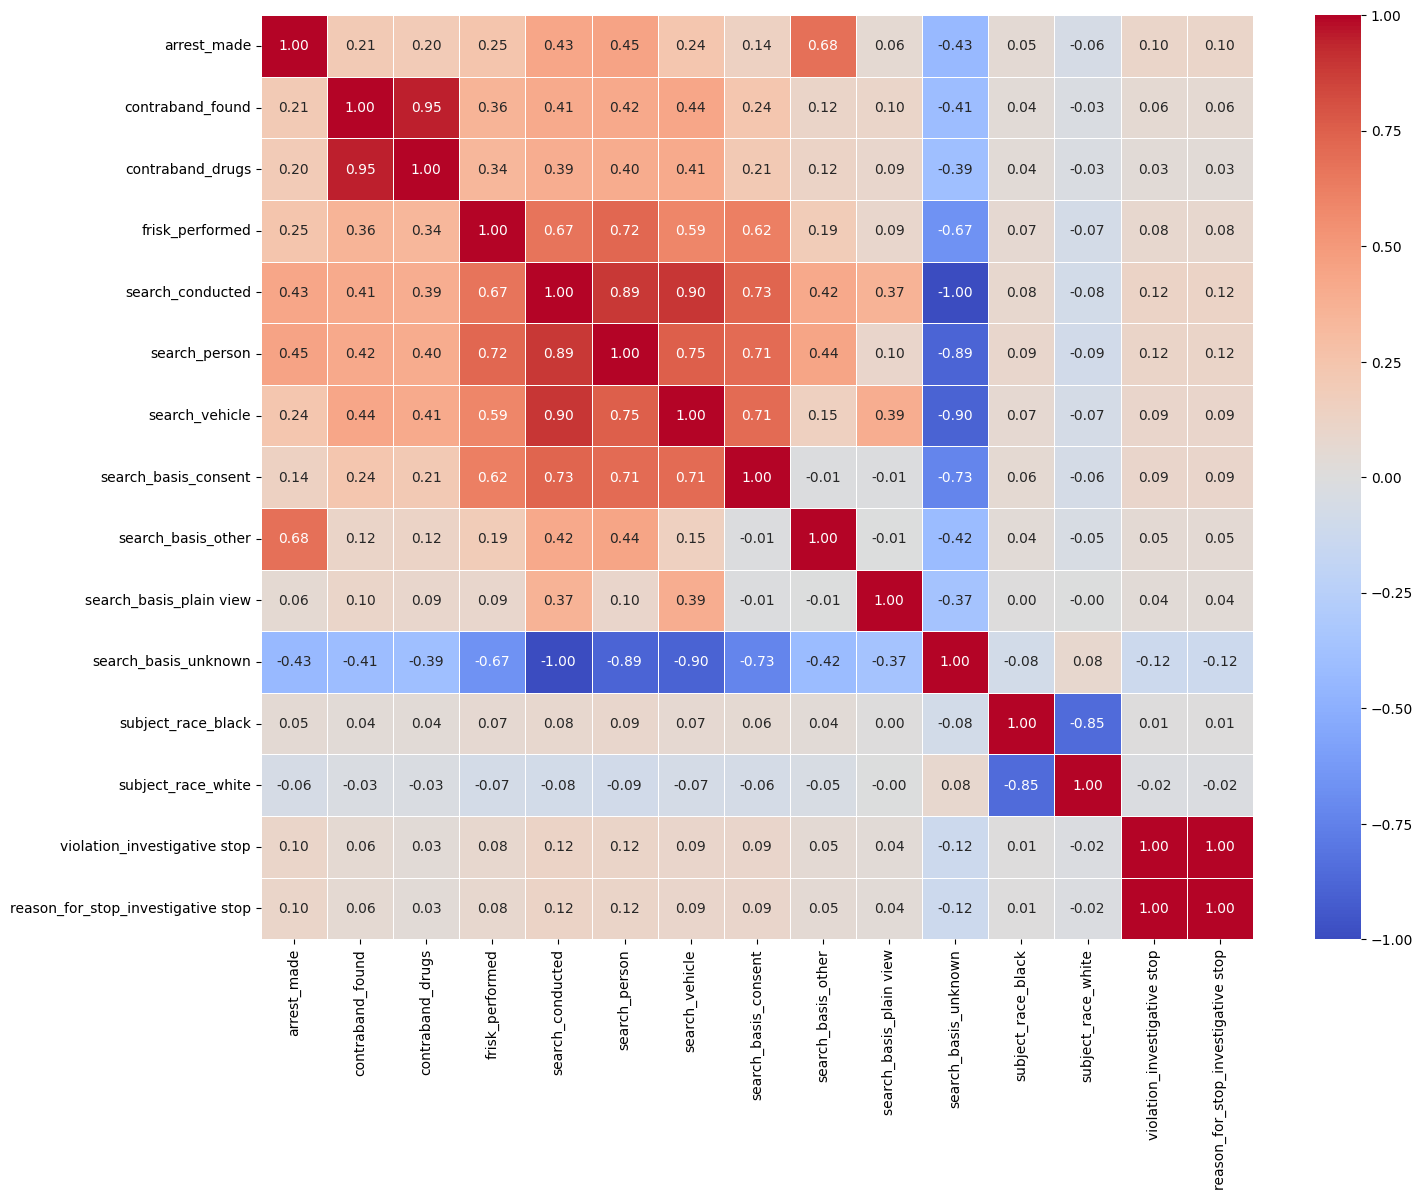

In [18]:
# Use a larger plot size.
fig, ax = plt.subplots(figsize=(16,12))

# Filter out variables with low correlation.
corr_threshold = 0.05
high_corr_vars = (df.corr().abs() > corr_threshold)['arrest_made']

# Plot the heatmap with cell value annotations and two-place precision.
sb.heatmap(df.corr().loc[high_corr_vars, high_corr_vars], ax=ax, annot=True, linewidths=0.4, cmap='coolwarm', fmt='.2f')

We can see that there are a few input features that stand out as far as being correlated in some way with `arrest_made`. Namely, `search_basis_other`, `search_person`, and `search_conducted` (of which the formter two are likely a subset) have a positive correlation, while `search_basis_unknown` has a similar magnitude *negative* correlation.

However, recall that the "unknown" value was our backfill value for NaNs in the original `search_basis` categorical column. Introducing that backfill value may have put too much emphasis on the `search_basis`. We can further see that `search_basis_unknown` is very strongly **colinear** with `search_conducted`, which is logical considering we backfilled "unknown" for NaNs in that column, which would naturally correspond to a False `search_conducted`. Considering this, we'll drop `search_basis_unknown` due to the high colinearity.

Another item to note is that the more strongly correlated features are all binary since they were either originally binary values or were derived from one-hot encoding.

Looking at the original `search_basis` breakdown, we can see that *other* is a relatively small subset. However, it still has a stronger correlation with `arrest_made` in the correlation matrix above.

<Axes: xlabel='search_basis', ylabel='count'>

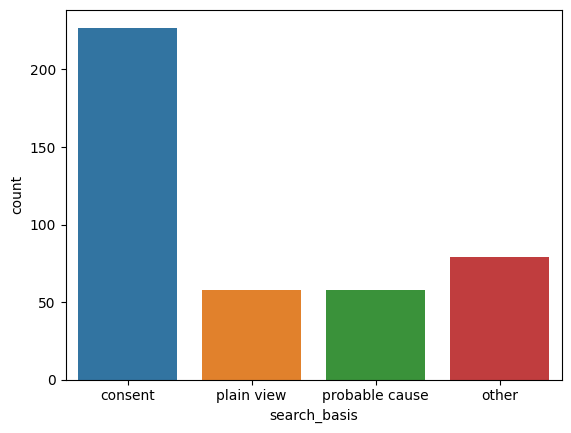

In [19]:
# View original `search_basis` breakdown (note the use of df_orig, which was a copy of the original loaded dataset before cleaning)
sb.countplot(x='search_basis', data=df_orig)

# Modeling and Analysis

We will now fit two different types of models on the dataset and compare the results.

As this is a (binary) classification problem, we'll use a Logistic Regression (classifier) and a Random Forest Classifier.

## Reload and Split

The EDA steps were performed on a subset of the full dataset to enable interactive operations to complete in a reasonable amount of time. We'll now load a much larger dataset for model fitting. This will include similar data cleaning steps as performed during EDA. However, some preprocessing will be performed as part of the training pipeline rather than explicitly as separate steps.

In [22]:
# Use a random subset of rows for model training/debugging.
# Uncomment these lines and the `skiprows` param in read_csv below to only load a subset.
# Attempting to load a fit models with the full dataset may not work in a notebook environment
# depending on available resources.

np.random.seed(42)
num_rows_approx=3_000_000
sample_rows=750_000

In [23]:
# Reload "full" dataset.
df_full = pd.read_csv(
    '/kaggle/input/police-stops-nashville-tn/tn_nashville_2020_04_01.csv',
    low_memory=False,
    skiprows=lambda x: x != 0 and np.random.uniform() > sample_rows/num_rows_approx,
)

***NOTE:*** We'll also drop `search_conducted` due to the extremely high **colinearity** with `search_basis_unknown` discovered during EDA.

In [24]:
# Drop raw_ columns and additional `drop_cols` identified during EDA..
drop_cols = [x for x in df_full.columns if x.startswith('raw_')]
drop_cols.extend(['notes', 'officer_id_hash', 'location', 'type', 'citation_issued', 'warning_issued', 'outcome', 'search_conducted'])
df_full.drop(drop_cols, axis=1, inplace=True)

# Backfill NaN with False for contraband_ columns.
df_full.contraband_found.fillna(False, inplace=True)
df_full.contraband_drugs.fillna(False, inplace=True)
df_full.contraband_weapons.fillna(False, inplace=True)

# Split year/month/day into separate columns.
df_full['year'] = df_full.date.apply(lambda x: int(x[:4]))
df_full['month'] = df_full.date.apply(lambda x: int(x[5:7]))
df_full['day'] = df_full.date.apply(lambda x: int(x[8:10]))
df_full.drop(['date'], axis=1, inplace=True)

# Extract hour into separate column and drop original time col.
df_full.dropna(subset=['time'], inplace=True)
df_full['hour'] = df_full.time.apply(lambda x: int(x[:2]))
df_full.drop(['time'], axis=1, inplace=True)

# Drop rows with NaN for arrest_made.
df_full.dropna(subset=['arrest_made'], inplace=True)

In [25]:
# Separate target from features.
y = df_full.arrest_made
X = df_full.drop(['arrest_made'], axis=1)

In [26]:
# Split data into separate training and validation sets.
from sklearn.model_selection import train_test_split
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.9, test_size=0.1, random_state=42)

## Preprocessing

Now we'll set up additional preprocessing using [Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) from sklearn. This allows us to perform things like backfilling missing values and one-hot encode categorical features. One-hot encoding is a light form of **feature engineering**.

In [27]:
# For categorical columns, we'll consider those with a relatively low cardinality to keep training memory lower. This will also
# identify the list of categorical columns for later preprocessing (such as one-hot encoding).
max_cardinality = 10
categorical_columns = [c for c in X_train_full.columns if X_train_full[c].dtype == 'object' and X_train_full[c].nunique() <= max_cardinality]
print(categorical_columns)

['precinct', 'subject_race', 'subject_sex', 'violation', 'frisk_performed', 'search_person', 'search_vehicle', 'search_basis', 'reason_for_stop']


In [28]:
# Similarly, we'll explicitly identify the numerical columns for any necessary numerical preprocessing.
numerical_columns = [c for c in X_train_full.columns if X_train_full[c].dtype in ['float64', 'int64']]
print(numerical_columns)

['lat', 'lng', 'reporting_area', 'subject_age', 'year', 'month', 'day', 'hour']


In [29]:
# Pull out our selected columns into X_train and X_valid from the full training and validation sets.
selected_columns = categorical_columns + numerical_columns
X_train = X_train_full[selected_columns].copy()
X_valid = X_valid_full[selected_columns].copy()

In [30]:
# Now build up preprocessing steps using SimpleImputer for missing values and OneHotEncoder for categorical features.
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# A SimpleImputer will be used to fill NaNs for numerical columns. StandardScaler will then
# scale values.
numerical_xformer = Pipeline(steps=[
    ('n_simpleimputer', SimpleImputer()),
    ('n_standardscaler', StandardScaler()),
])

# Categorical columns will also use a SimpleImputer to fill NaNs, but using the "most_frequent" strategy
# instead of the default "mean" strategy. This part of the pipeline will also one-hot encode categorical
# columns.
categorical_xformer = Pipeline(steps=[
    ('si', SimpleImputer(strategy='most_frequent')),
    ('oh', OneHotEncoder(handle_unknown='ignore')),
])

# Tie the different transformers together based on column types (determined above and
# stored in numerical_columns and categorical_columns).
pp = ColumnTransformer(transformers=[
    ('numerical', numerical_xformer, numerical_columns),
    ('categorical', categorical_xformer, categorical_columns),
])

## Model Training - Logistic Regression

As a first model, we'll use the [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier as provided by `sklearn`.

In [31]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000)

lr_pipeline = Pipeline(steps=[
    ('preprocessor', pp),
    ('model', lr_model),
])

lr_pipeline.fit(X_train, y_train.astype(int))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('n_simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('n_standardscaler',
                                                                   StandardScaler())]),
                                                  ['lat', 'lng',
                                                   'reporting_area',
                                                   'subject_age', 'year',
                                                   'month', 'day', 'hour']),
                                                 ('categorical',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['precinct', 'subject_race',
                                                   'subject_sex', 'violation',
                                                   'frisk_performed',
                                                   'search_person',
                                                   'search_vehicle',
                                                   'search_basis',
                                                   'reason_for_stop'])])),
                ('model', LogisticRegression(max_iter=1000))])

In [32]:
lr_preds = lr_pipeline.predict(X_valid)

accuracy = accuracy_score(y_valid.astype(int), lr_preds)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.9899500745639629


Now let's extract the coefficients and relate them to the input features to determine which are most important.

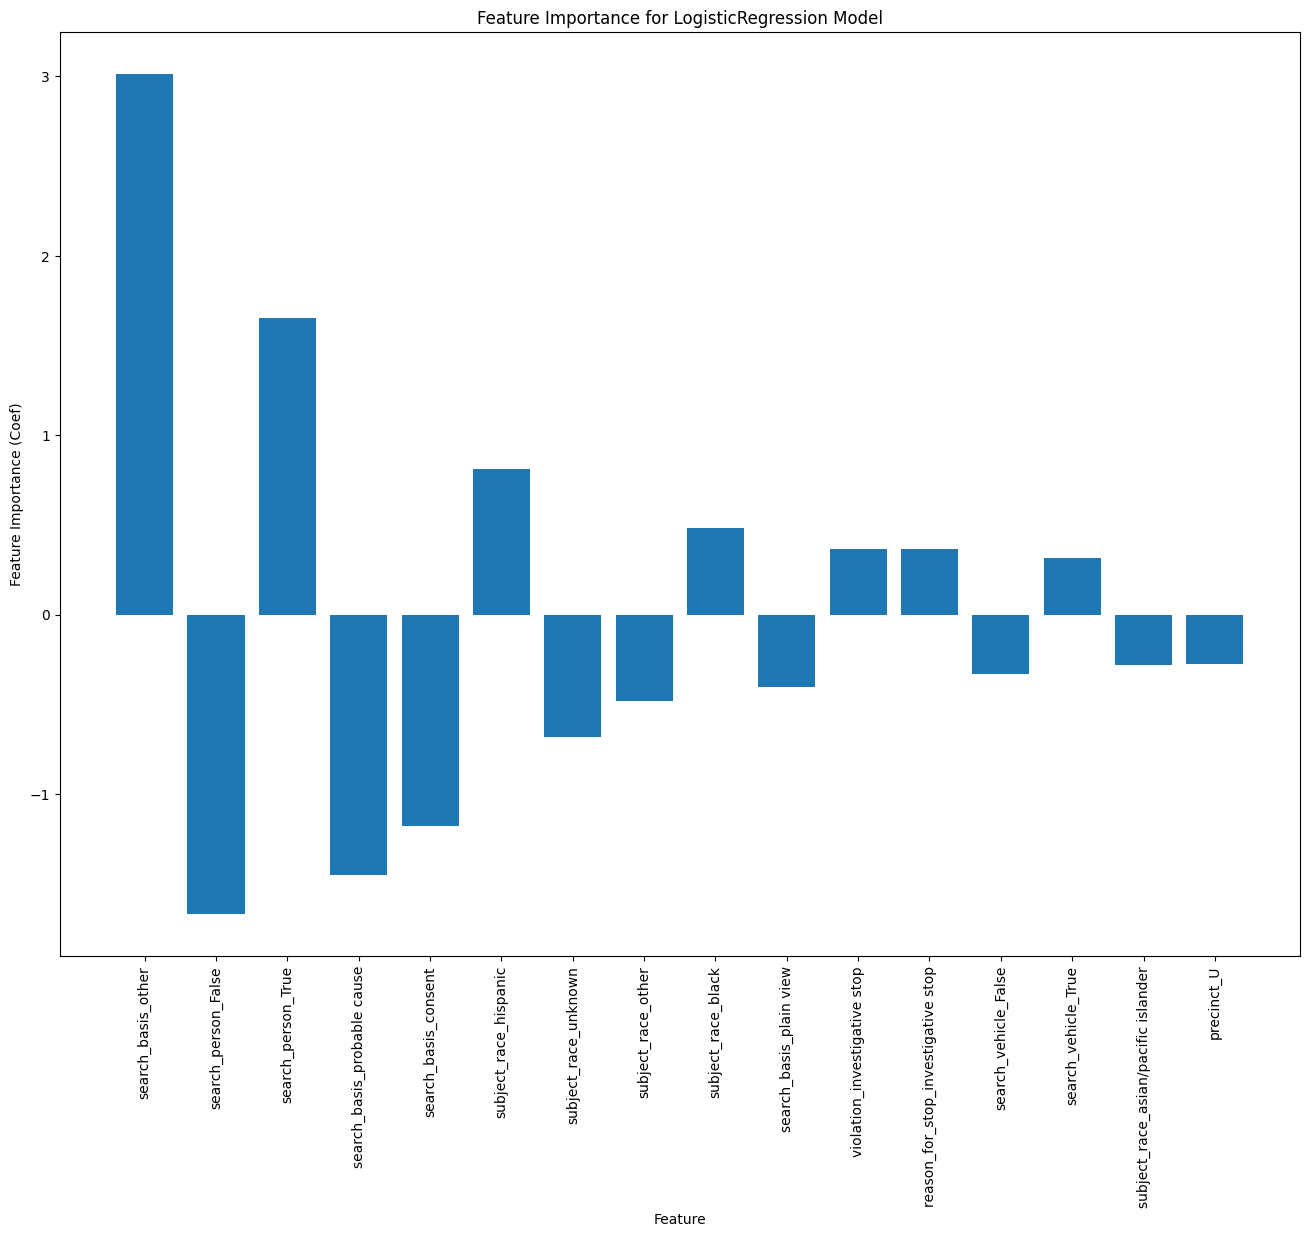

In [33]:
# len(lr_model.coef_[0])
# dir(lr_pipeline)
# lr_pipeline[:-1].get_feature_names_out()

# Extract coefficients/importance factors and feature names.
feature_importance = lr_model.coef_[0]
feature_names = lr_pipeline[:-1].get_feature_names_out()

# Join and sort feature names/coefficients by absolute value.
feature_importance_sorted = sorted(zip(feature_names, feature_importance), key=lambda x: abs(x[1]), reverse=True)
labels = []
vals = []

# Filter based on simple threshold.
for l, v in feature_importance_sorted:
    if abs(v) > 0.2:
        labels.append(l.replace('numerical__', '').replace('categorical__', ''))
        vals.append(v)

# Plot results.
plt.subplots(figsize=(16,12))
plt.bar(labels, vals)
plt.xlabel('Feature')
plt.xticks(rotation=90)
plt.ylabel('Feature Importance (Coef)')
plt.title('Feature Importance for LogisticRegression Model')
plt.show()

## Model Training - Random Forest

As a comparison model, we'll use the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) as provided by `sklearn`.

In [34]:
# As a comparison, we'll train a RandomForestClassifier using default hyperparameters.
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()

rf_pipeline = Pipeline(steps=[
    ('preprocessor', pp),
    ('model', rf_model),
])

rf_pipeline.fit(X_train, y_train.astype(int))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('n_simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('n_standardscaler',
                                                                   StandardScaler())]),
                                                  ['lat', 'lng',
                                                   'reporting_area',
                                                   'subject_age', 'year',
                                                   'month', 'day', 'hour']),
                                                 ('categorical',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['precinct', 'subject_race',
                                                   'subject_sex', 'violation',
                                                   'frisk_performed',
                                                   'search_person',
                                                   'search_vehicle',
                                                   'search_basis',
                                                   'reason_for_stop'])])),
                ('model', RandomForestClassifier())])

In [35]:
rf_preds = rf_pipeline.predict(X_valid)

accuracy = accuracy_score(y_valid.astype(int), rf_preds)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.9900408480840304


Now let's look at the feature importance for the RandomForestClassifier.

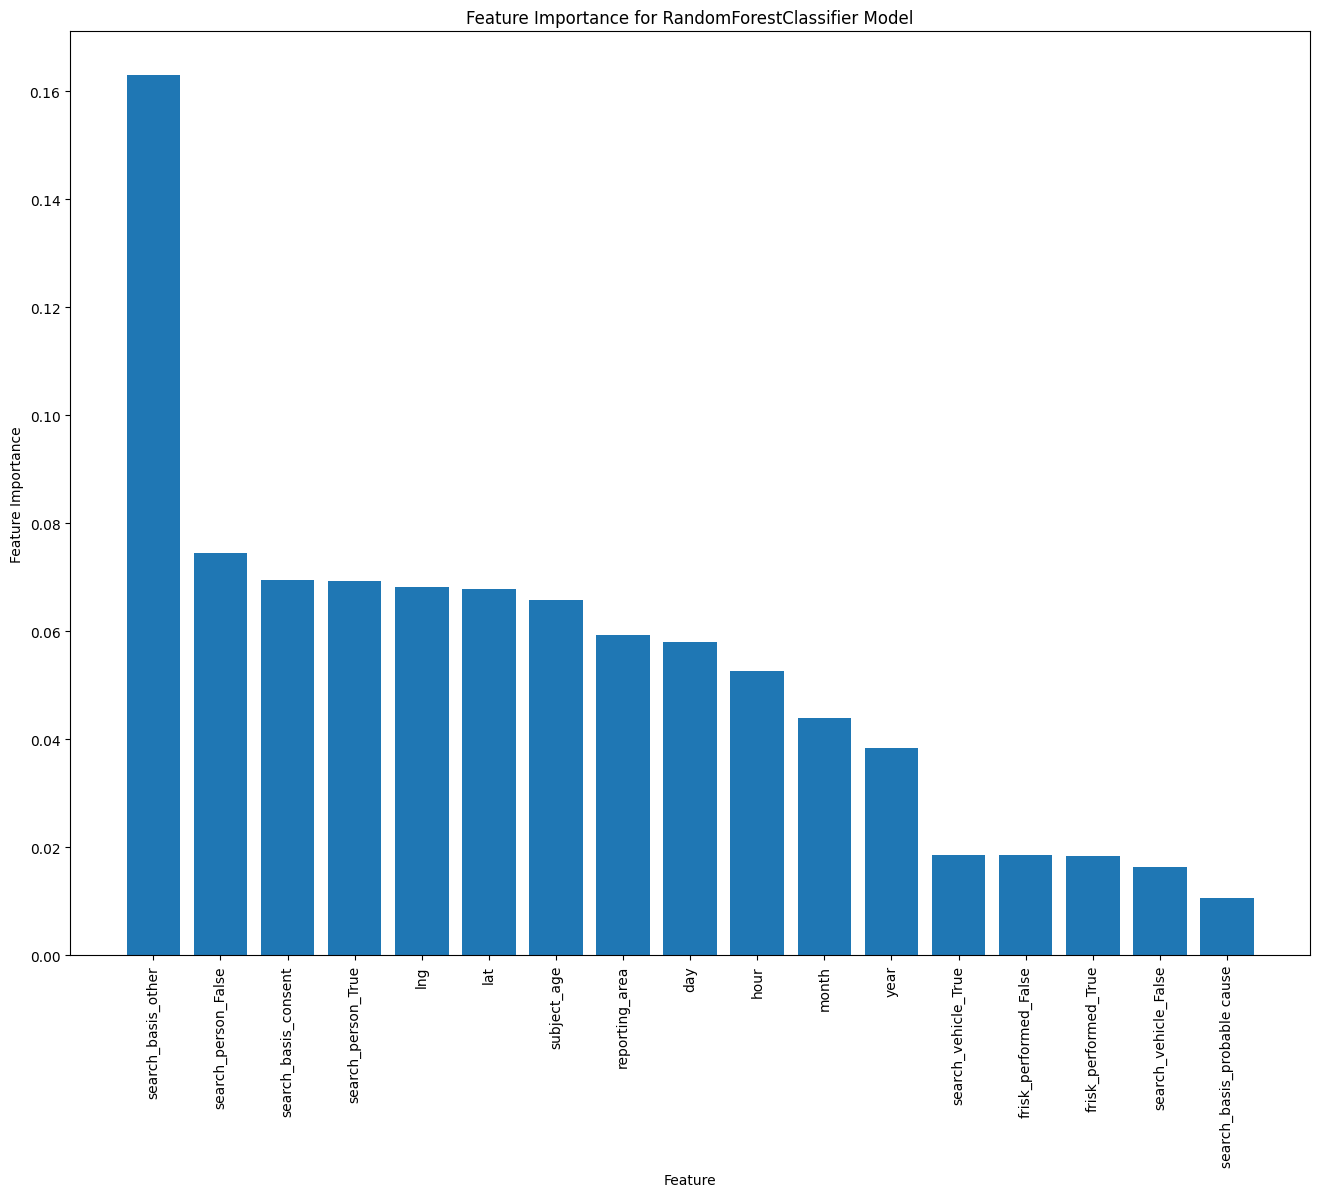

In [36]:
# Extract coefficients/importance factors and feature names.
feature_importance = rf_model.feature_importances_
feature_names = rf_pipeline[:-1].get_feature_names_out()

# Join and sort feature names/coefficients by absolute value.
feature_importance_sorted = sorted(zip(feature_names, feature_importance), key=lambda x: abs(x[1]), reverse=True)
labels = []
vals = []

# Filter based on simple threshold.
for l, v in feature_importance_sorted:
    if abs(v) > 1e-2:
        labels.append(l.replace('numerical__', '').replace('categorical__', ''))
        vals.append(v)

# Plot results.
plt.subplots(figsize=(16,12))
plt.bar(labels, vals)
plt.xlabel('Feature')
plt.xticks(rotation=90)
plt.ylabel('Feature Importance')
plt.title('Feature Importance for RandomForestClassifier Model')
plt.show()

## Visualizations

We can now use some visualizations to help evaluate the performance of the LogisticRegression vs. the RandomForestClassifier models.

### Confusion Matrix

To start with, we'll look at the confusion matrix for Logistic Regression vs. Random Forest versions of the models.

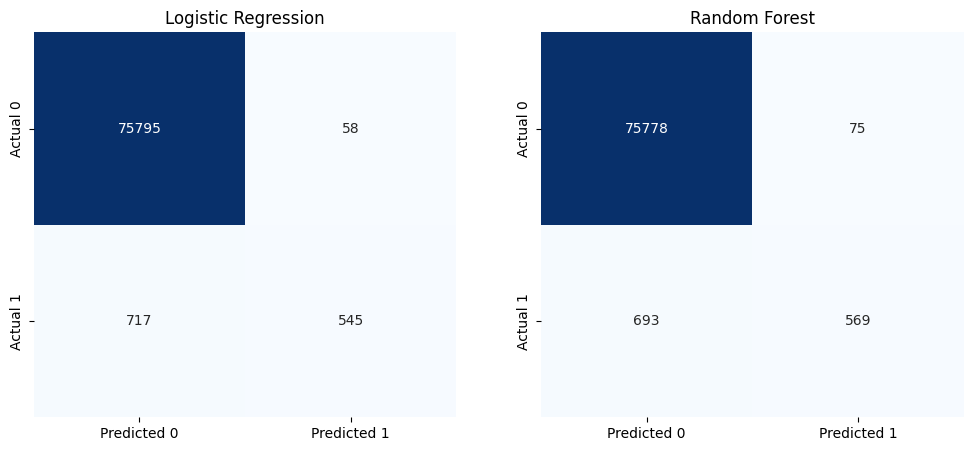

In [37]:
from sklearn.metrics import confusion_matrix

# Set up for two plots.
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix for Logistic Regression.
cm_lr = confusion_matrix(y_valid.astype(int), lr_preds)
sb.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'], ax=axes[0])
axes[0].set_title('Logistic Regression')

# Plot confusion matrix for Random Forest.
cm_rf = confusion_matrix(y_valid.astype(int), rf_preds)
sb.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'], ax=axes[1])
axes[1].set_title('Random Forest')

plt.show()

The confusion matrices also show that overall accuracy on the test/validation set for the *Logistic Regression* and *Random Forest* models are quite close to each other for prediction of no arrest. In these cases, **specificity** is very high (correctly predicting no arrest).

However, **sensitivity** is quite low. As we can see below, sensitivity for both models is less than 50%, indicating that less than half of arrests were correctly predicted.

In [38]:
def pss(title, cm):
    true_negatives, false_positives, false_negatives, true_positives = cm.ravel()

    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)

    print(f'========== {title} ==========')
    print('Sensitivity:', sensitivity)
    print('Specificity:', specificity)
    print('')

pss('Logistic Regression', cm_lr)
pss('Random Forest', cm_rf)

========== Logistic Regression ==========
Sensitivity: 0.4318541996830428
Specificity: 0.9992353631365931

========== Random Forest ==========
Sensitivity: 0.4508716323296355
Specificity: 0.9990112454352498



### ROC/AUC

We can use an ROC (Reciever Operating Characteristics) curve along with AUC (Area Under the Curve) to further examine true-positive (TP) and false-positive (FP) rates for both models.

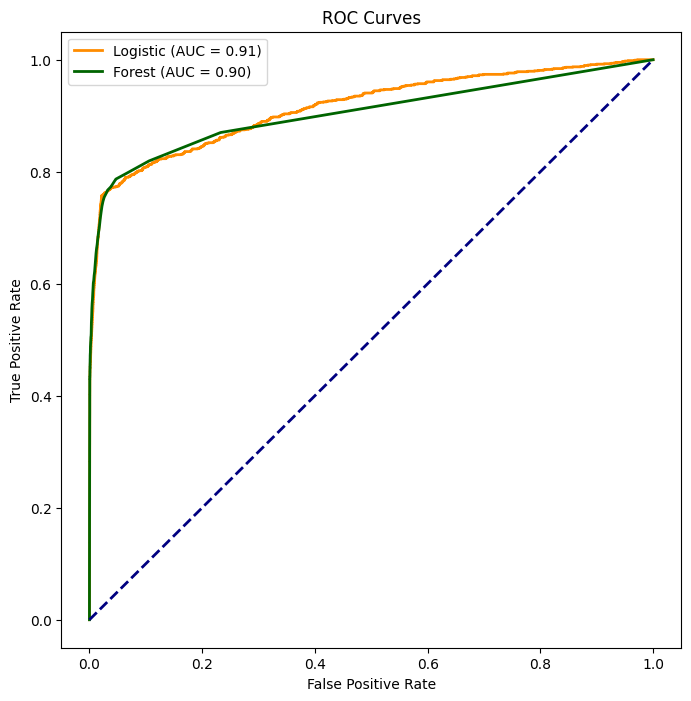

In [39]:
from sklearn.metrics import roc_curve, auc

# Get FP rate, TP rate, and AUC for Logistic Regression.
lr_fpr, lr_tpr, _ = roc_curve(y_valid.astype(int), lr_pipeline.predict_proba(X_valid)[:, 1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

# Get FP rate, TP rate, and AUC for Random Forest.
rf_fpr, rf_tpr, _ = roc_curve(y_valid.astype(int), rf_pipeline.predict_proba(X_valid)[:, 1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

# Set up a slightly larger than default plot size.
fig, ax = plt.subplots(figsize=(8, 8))

plt.plot(lr_fpr, lr_tpr, color='darkorange', lw=2, label='Logistic (AUC = {:.2f})'.format(lr_roc_auc))
plt.plot(rf_fpr, rf_tpr, color='darkgreen', lw=2, label='Forest (AUC = {:.2f})'.format(rf_roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

The curves are similar in shape, but the Logistic Regression model has a slighly higher AUC. This **very generally** means that it is a "better" model overall, but the context of the problem and question we're trying to answer plays more heavily into a decision of model choice.

In this case, a False Positive (FP) would represent predicting an arrest when the actual data showed no arrest. As can be seen on the ROC curve, the FP rate is very low until we reach about 80% True Positive (TP) rate, after which FP starts to increase dramatically.

If the goal were to reduce false arrests, for example, we would want the decision boundary of the models to live around the inflection point on the ROC curve (approximately at the 80% TP rate). The model would incorrectly "miss" about 20% of arrests, but the false arrests would stay very low.

# Conclusion and Retrospective

Based on raw model performance, the Logistic Regression and Random Forest methods performed very similar on this dataset. They each demonstrated similar sensitivity and specificity as well as ROC and AUC, though the Logistic Regression had a slightly higher overall AUC around the middle of the false positive range. Both models ended up with high feature importance for the `search_basis_other` feature, which matched what we originally noticed in the correlation matrix. After `search_basis_other`, additional search related features showed up near the top of the list. Clearly, if a search of some kind is performed, the chances of an arrest increase.

Due to the relatively very small number of arrests, both models had high specificity but low sensitivity. Depending on the use case for a model, one would likely want to adjust the decision threshold to avoid False Positives in cases where misclassification of this type would outweigh the model "missing" some True Positives.

As follow-up work, it would be interesting to go back and model a different target variable that has a better distribution of values and is less heavily weighted toward one particular value. Additionally, further investigation into colinearity or multicolinearity of other features is likely warranted.

# References

Multiple sources were used for references during creation of this notebook:

* Pandas API documentation: https://pandas.pydata.org/docs/reference/index.html
* Pandas User Guide: https://pandas.pydata.org/docs/user_guide/index.html
* sklearn library documentation: https://scikit-learn.org/stable/index.html
* Course lessons from CSCA 5662: https://www.colorado.edu/cs/academics/online-programs/mscs-coursera/csca5622
* Seaborn documentation: https://seaborn.pydata.org/
* sklearn ROC plots: https://scikit-learn.org/1.1/auto_examples/model_selection/plot_roc.html
